# Building a damage assessment system for aerospace industry 

**Context** 

We aim to build a machine learning system that will determine, for a given damage on the aircraft, if it is allowable or not : 

- Allowable damage (output = 0 , negative) means that aircraft can keep flying without any danger. Only an inspection program is recommended in this case.  
- Not allowable damage (output = 1, positive) means that aircraft should be kept on ground for maintenance. The airframer should be contacted for damage justification. This process is costy and needs good planification.  

Knowing if a damage is not allowable could be a good benefit for airlines. Knowing it in advance without specifying all required features is also more intresting. 

**Summary**

We assume we have the necessary data (sensitive data). We explore it with Pandas, Numpy Seaborn and Pyplot. We make predictions with some appropriate machine learning algorithms such as linearSVC or DecisionTree. We calculate and compare F1 scores and computing times then we pick the one who suits better our business problem.
Finally, we investigate the possibility to provide a probabilistic system able to provide relevant answers without knowing all the features. 


# Project  
## Import libraries

In [1]:
# author: houcem
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
np.random.seed(0)

## Importing data set 
The data is sensitive. In this project no exhaustive details are provided about it. 

In [2]:
#Loard the data
data = pd.read_csv('/home/houcem/Bureau/Training_data1.csv')
#drop the index column 
data = data.drop("Unnamed: 0",axis = 1)
data.head()
print("Damage data matrix shape is " , data.shape)
print("Its type is :  ",  type(data))

Damage data matrix shape is  (1000, 10)
Its type is :   <class 'pandas.core.frame.DataFrame'>


In [3]:
data.head()

,x1,x2,x3,x4,x5,x6,x7,x8,x9,y
0,False,True,False,0.24,1.17,10.76,232.16,69.30,334.05,0
1,False,True,False,0.23,1.16,11.17,144.87,107.79,179.21,0
2,False,True,False,0.16,1.23,6.96,94.04,65.41,97.57,0
3,False,False,False,0.71,1.51,42.00,422.47,244.88,423.47,1
4,False,True,False,0.14,1.72,5.79,92.03,64.42,93.43,0


We are provided with a data set of 1000 damages. Each damage is described with 9 features. We can notice that x1,x2,x4 are boolean features and that x3..x9 are numerical. This data is sensitive, so no exaustive details can be provided about it. 

**Features and Labels **

**Features**

**(x1,x2,x3) : booleans** 

We know that x1,x2 and x3 are answers to some basic questions about the damage properties : 
- Is there any other damage in the area ? 
- Is there more than one different damage type in the area ? 
- Does the damage cross a riveted area ?

**(x4,x5,x6,x7,x8,x9) : numerical** 

These features are related to geometric measurement : distances, thicknesses and diameters related to damage. 
For example :  x5 describes the nominal thickness of the damaged panel  

**Label**

**y : 0 or 1 **

- A damage labeled 0 is a negative damage. That means that it doesn't represent a major danger. Hence, the airplane can keep flying safely. 
- A damage labeled 1 is positive damage. That means that it requires to keep the airplane on ground (AOG) and send it to a maintenance center or contact the airframer

## Quick insights 

In [4]:
#Let's get an overall description of our numerical values 
data.describe()

,x4,x5,x6,x7,x8,x9,y
count,1000.00000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,0.33014,1.434470,18.851180,260.368290,76.672000,320.792680,0.250000
std,0.32173,0.330876,23.829437,156.693256,81.221931,152.445572,0.433229
min,0.10000,1.000000,4.010000,1.980000,0.000000,3.800000,0.000000
25%,0.14000,1.140000,6.440000,113.570000,0.000000,183.005000,0.000000
50%,0.20000,1.270000,9.610000,251.085000,64.175000,340.975000,0.000000
75%,0.30250,1.730000,14.805000,430.910000,105.957500,484.952500,0.250000
max,1.59000,2.000000,123.410000,499.770000,495.920000,500.770000,1.000000


- y.mean() = 0.25 , That means that 25% of provided data is positive. We clearly have a problem of unbalanced data. Choosing F1_score as a performance metric is a best practice 

- At least 25 % of x8 values are equal to 0. Let's investigate this further with histograms  

## Define X and y

In [5]:
#preprocess data 
X = data.drop("y", axis = 1)
y = data.y
# data set to use 
print(" the shape of X is " , X.shape)
print(" the shape of y is ", y.shape)
print(" Positive cases represent {}% of all data".format(100*y.mean()))

 the shape of X is  (1000, 9)
 the shape of y is  (1000,)
 Positive cases represent 25.0% of all data


## Descriptive statistics 

/home/houcem/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  """Entry point for launching an IPython kernel.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7faecb9262e8>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7faec8c83898>]], dtype=object)

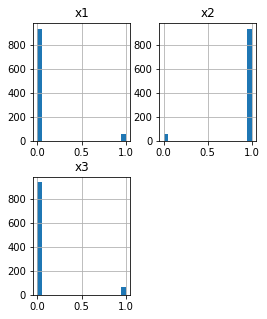

In [6]:
X.ix[:,0:3].hist(figsize=[4,5], bins= 20)

- We notive that each boolean feature takes a specific value for 90% of the time. 
For instance, x3 is equal to FALSE for 90% of the time. 


Let's investigate more this insight and see the impact on classification


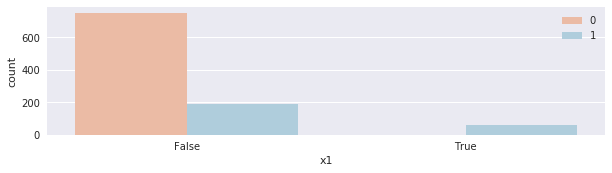

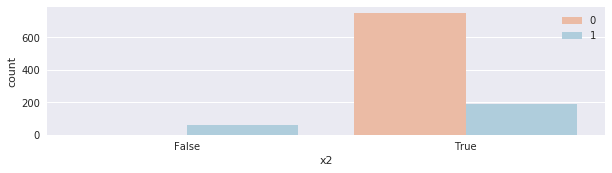

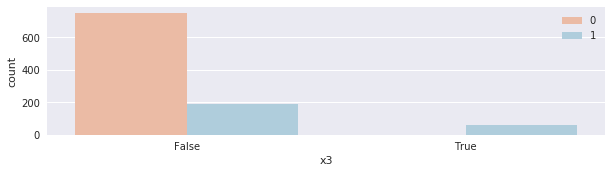

In [7]:
import seaborn as sns 
figsz =[10,8]
features = ["x1","x2","x3"] 
for i,name in enumerate(features):
    sns.set(style="darkgrid")
    plt.figure(figsize= figsz) 
    plt.subplot(3, 1, i+1)
    ax = sns.countplot(x= name, data = X ,hue=y, palette = "RdBu")
    # Add legend to plot
    plt.legend()
    plt.show()

- It is clear that x1,x2,x3 have an important influence on classification.
- For example we can say that : probably every time that x3 is equal to True , the damage will be positive. 

A decision tree model can be a good candidate to solve this classification problem 

Now let's have some insights about the other features

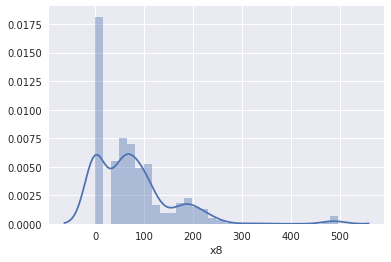

In [8]:
#x8 distribution 
sns.distplot(X.x8,bins=30)
plt.show()

- In x8 histogram we can notice that it is not a normal distribution. 
Some values are more luckily to occur. The value 0 is particularly present

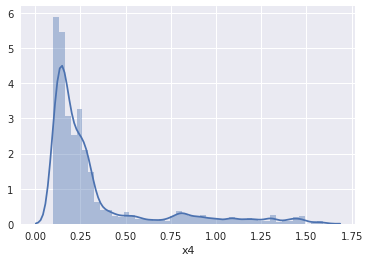

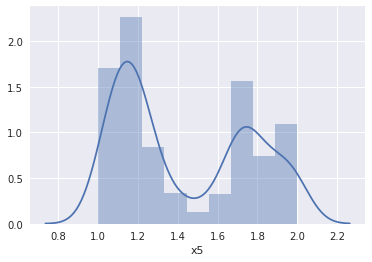

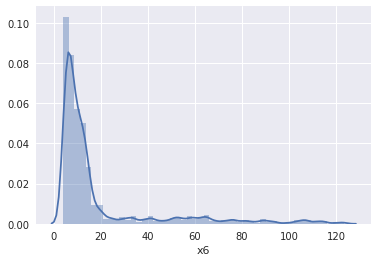

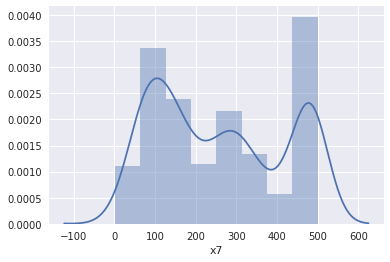

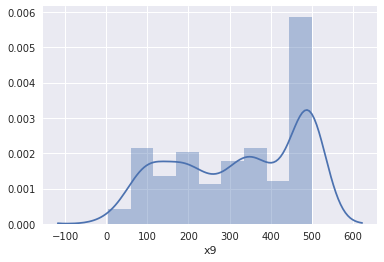

In [9]:
#other features distribution 
for i in ["x4","x5","x6","x7","x9"]:
    sns.distplot(X[i])
    plt.show()

Let's see how positive and negative damages are related to these features distributions 

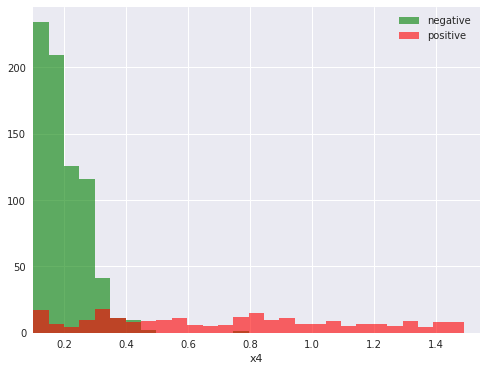

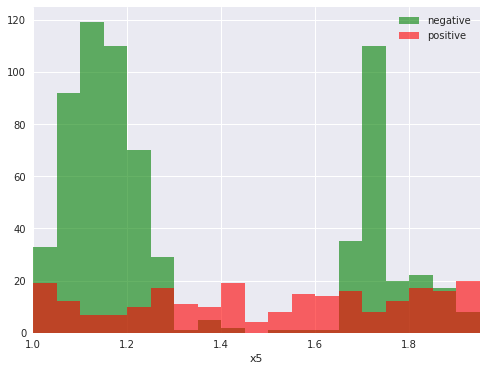

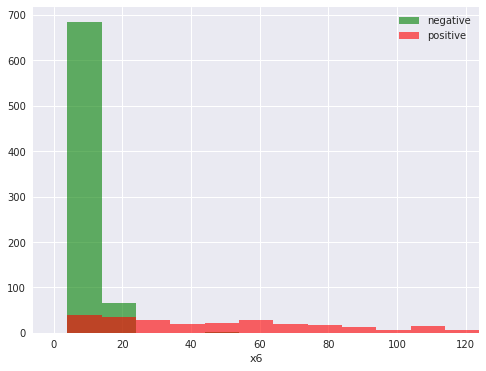

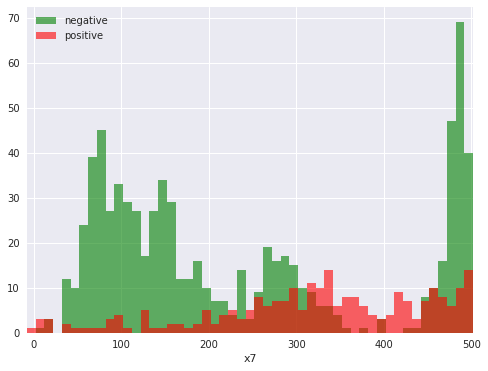

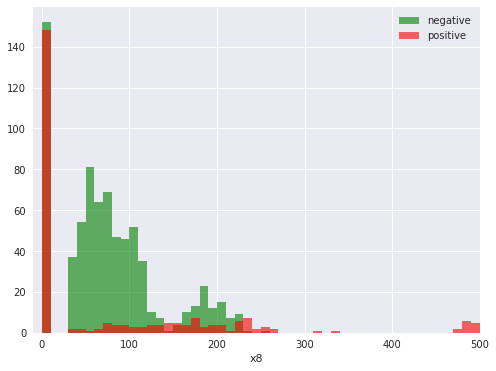

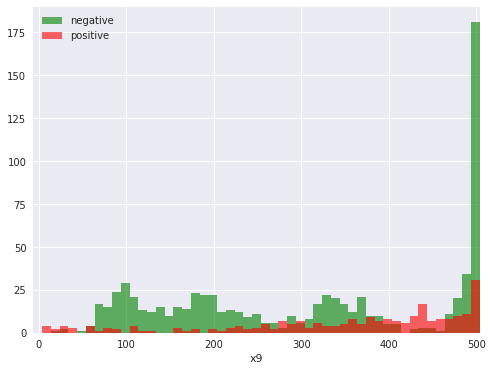

In [10]:
def plot_feature(data, outcomes, key):
    # Merge data and outcomes into single dataframe
    all_data = pd.concat([data, outcomes.to_frame()], axis = 1)
    # Create outcomes DataFrame
    all_data = all_data[[key, 'y']]
    # Create plotting figure
    plt.figure(figsize=(8,6))
    # Remove NaN values from Age data
    all_data = all_data[~np.isnan(all_data[key])]
    # Divide the range of data into bins and count survival rates
    min_value = all_data[key].min()
    max_value = all_data[key].max()
    value_range = max_value - min_value
    if key in ["x6", "x7", "x8", "x9"]:
        bins = np.arange(min_value - 10 , max_value + 10, 10)
    else:
        if key == "x5": 
            bins = np.arange(1, 2, 0.05)
        else:
            bins = np.arange(min_value, max_value, (value_range/30))
    # Overlay each bin's outcome rates
    neg_vals = all_data[all_data['y'] == 0][key].reset_index(drop = True)
    pos_vals = all_data[all_data['y'] == 1][key].reset_index(drop = True)
    plt.hist(neg_vals, bins = bins, alpha = 0.6, color = 'green', label = 'negative')
    plt.hist(pos_vals, bins = bins, alpha = 0.6,color = 'red', label = 'positive')
    plt.xlabel(key)
    # Add legend to plot
    plt.xlim(bins.min(), bins.max())
    plt.legend(framealpha = 0.8)

features = ["x4","x5","x6","x7","x8","x9"] 
for i in features:
    plot_feature(X, y, i)

We notice that we can find a number of thresholds that can help to determine if a damage is positive. For example, by seeing x4 last histogram, we can say that if x4 > 0.5 then the damage is positive.  Also, if x8 is equal to 0 then the damage is more luckily to be positive. 

Let's have another perspective with the help of scatter matrix 

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7faebfde00f0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7faebfa6e400>]], dtype=object)

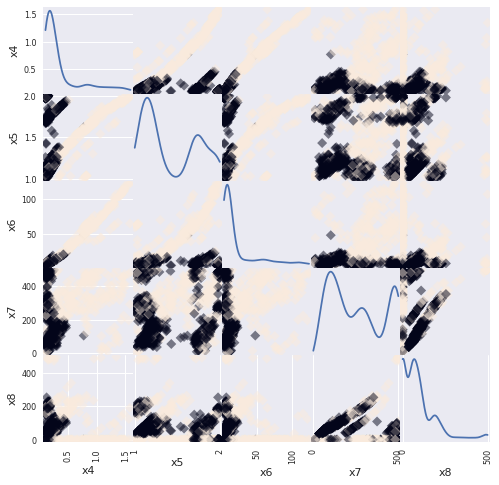

In [11]:
pd.plotting.scatter_matrix(X.ix[:,3:(-1)],c=y, figsize= [8, 8], s= 50 , marker = 'D', diagonal = "kde")

# Preprocess categorical features 
Before doing any machine learning, we should replace boolean features (or categorical) with numerical features. 

In [12]:
for i in ["x1","x2","x3"]:
    X[i] = X[i].replace(to_replace = [True,False], value = [1,0])
X.head()

,x1,x2,x3,x4,x5,x6,x7,x8,x9
0,0,1,0,0.24,1.17,10.76,232.16,69.30,334.05
1,0,1,0,0.23,1.16,11.17,144.87,107.79,179.21
2,0,1,0,0.16,1.23,6.96,94.04,65.41,97.57
3,0,0,0,0.71,1.51,42.00,422.47,244.88,423.47
4,0,1,0,0.14,1.72,5.79,92.03,64.42,93.43


# Train test split 

In [13]:
from sklearn.model_selection import train_test_split

#let's conduct a stratified train test split. 10 % of the data set is dedicated to testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1,
                                                    random_state = 42, 
                                                    stratify = y) 

In [14]:
# check the split 
print ("Training set has {} samples ".format(X_train.shape[0]) ) 
print ("Testing set has {} samples ".format(X_test.shape[0]) ) 
print ("Positive damages proportion in training set is ", y_train.mean())
print ("Positive damages proportion in testing set is ", y_test.mean())

Training set has 900 samples 
Testing set has 100 samples 
Positive damages proportion in training set is  0.25
Positive damages proportion in testing set is  0.25


# Some useful functions for classification 

- train_classifier - takes as input a classifier and training data and fits the classifier to the data.

- predict_labels - takes as input a fit classifier, features, and a target labeling and makes predictions using the F1 score.

- train_predict - takes as input a classifier, and the training and testing data, and performs train_clasifier and predict_labels.
This function will report the F1 score for both the training and testing data separately.

In [15]:
# define useful functions 
from time import time 
from sklearn.metrics import f1_score

def train_classifier(clf, X_train, y_train):
    #Fits a classifier to the training data.

    # Start the clock, train the classifier, then stop the clock
    start = time()
    clf.fit(X_train, y_train)
    end = time()

    # Print the results
    print("Trained model in " + str(end - start) +  " seconds" )


def predict_labels(clf, features, target):
    #Makes predictions using a fit classifier based on F1 score

    # Start the clock, make predictions, then stop the clock
    start = time()
    y_pred = clf.predict(features)
    end = time()

    # Print and return results
    print("Made predictions in {:.4f} seconds.".format(end - start))
    return f1_score(target.values, y_pred, pos_label = 1 )


def train_predict(clf, X_train, y_train, X_test, y_test):
    #Train and predict using a classifer based on F1 score

    # Indicate the classifier and the training set size
    print("")
    print("Training a {} using a training set size of {}. . .".format(clf.__class__.__name__, len(X_train)))

    # Train the classifier
    train_classifier(clf, X_train, y_train)

    # Print the results of prediction for both training and testing
    print("F1 score for training set: {:.4f}.".format(predict_labels(clf, X_train, y_train)))
    print("F1 score for test set: {:.4f}.".format(predict_labels(clf, X_test, y_test)))


# Algorithms 


We know that we have a supervised learning classification problem. One good practice in machine learning is to start by a number of different algorithms. Then, seeing their preliminar results (without any preliminar optimisation) will help to pick the one which suits the better your needs.  
Scalability, computing costs and accuracy can be among the criteria which will be taken into consideration during the selection process.


*** How are we going to choose ? ***


Let's start with a list of algorithms and then compare them according to these criteria : 

- F1 scores : very important to use with unbalanced data. Having a higher F1 score is better. 
- Transparency : is the ability to understand how and why the classifier takes a decision. This topic is very relevant to aerospace industry. 
- How much data is needed to get a good classifier : this question is important because in our context, we don't usually have large amounts of examples 
- Training times

In [16]:
# import different algorithms  
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.neural_network import MLPClassifier 
from sklearn.tree import DecisionTreeClassifier

In [17]:
# Initialize models
clf_A = GaussianNB()
clf_B = LogisticRegression(random_state=42)
clf_C = LinearSVC(random_state=42)
clf_D = MLPClassifier(random_state=42)
clf_E = DecisionTreeClassifier(random_state = 42) 

In [18]:
#the training data size is 900. Let's increase the training data size progressively 
n_training_examples = [300, 600, 900]

for clf in [clf_A, clf_B, clf_C, clf_D, clf_E]:
    print("\n{}: \n".format(clf.__class__.__name__))
    for n in n_training_examples:
        train_predict(clf, X_train[:n], y_train[:n], X_test, y_test)



GaussianNB: 


Training a GaussianNB using a training set size of 300. . .
Trained model in 0.00292205810546875 seconds
Made predictions in 0.0012 seconds.
F1 score for training set: 0.9333.
Made predictions in 0.0013 seconds.
F1 score for test set: 0.8936.

Training a GaussianNB using a training set size of 600. . .
Trained model in 0.0019998550415039062 seconds
Made predictions in 0.0012 seconds.
F1 score for training set: 0.9286.
Made predictions in 0.0011 seconds.
F1 score for test set: 0.8936.

Training a GaussianNB using a training set size of 900. . .
Trained model in 0.0037462711334228516 seconds
Made predictions in 0.0014 seconds.
F1 score for training set: 0.9387.
Made predictions in 0.0011 seconds.
F1 score for test set: 0.8936.

LogisticRegression: 


Training a LogisticRegression using a training set size of 300. . .
Trained model in 0.005715847015380859 seconds
Made predictions in 0.0009 seconds.
F1 score for training set: 0.9333.
Made predictions in 0.0006 seconds.
F1 s

***Classifer 1 - Naive Bayes (GaussianNB)***

| Training Set Size | Training Time | Prediction Time (test)| F1 Score (train)| F1 Score (test)| 
| ----| ------------ | -------- | ----------- | ------------ |
| 300 |    0.0025    | 0.0007   |  0.9333     |   0.8936     |
| 600 |    0.0012    | 0.0007   |  0.9286     |   0.8936     |
| 900 |    0.0012    | 0.0007   |  0.9387     |   0.8936     |


***Classifer 2 - Logistic Regression***

| Training Set Size | Training Time | Prediction Time (test)| F1 Score (train)| F1 Score (test)| 
| ----| ------------ | -------- | ----------- | ------------ |
| 300 |    0.1043    | 0.0346   |  0.9333     |   0.8444     |
| 600 |    0.0132    | 0.0012   |  0.9286     |   0.8936     |
| 900 |    0.0150    | 0.0248   |  0.9362     |   0.9167     |

***Classifier 3 - Support vector machine : Linear SVC***

| Training Set Size | Training Time | Prediction Time (test)| F1 Score (train)| F1 Score (test)| 
| ----| ------------ | -------- | ----------- | ------------ |
| 300 |    0.0216    | 0.0005   |  0.8293     |   0.6667     |
| 600 |    0.0298    | 0.0005   |  0.9123     |   0.8000     |
| 900 |    0.0550    | 0.0005   |  0.8402     |   0.7619     |

***Classifier 4 - Neural Network  : MLPClassifier***

| Training Set Size | Training Time | Prediction Time (test)| F1 Score (train)| F1 Score (test)| 
| ----| ------------ | -------- | ----------- | ------------ |
| 300 |    0.1033    | 0.0007   |  0.1299     |   0.3871     |
| 600 |    0.0253    | 0.0010   |  0.1366     |   0.3871     |
| 900 |    0.3125    | 0.0011   |  0.9198     |   0.9200     |

***Classifier 5 - Decision tree : DecisionTreeClassifier***

| Training Set Size | Training Time | Prediction Time (test)| F1 Score (train)| F1 Score (test)| 
| ----| ------------ | -------- | ----------- | ------------ |
| 300 |    0.0013    | 0.0003   |  1.0000     |   0.9200     |
| 600 |    0.0027    | 0.0003   |  1.0000     |   0.9412     |
| 900 |    0.0049    | 0.0007   |  1.0000     |   0.9231     |


- We eliminate MLPClassifier for two main reasons : it needs relatively more examples than other algorithms and also because of its lack of  transparency.  
- SVC is also eliminated because of low F1 scores if compared to  others 
- Logistic regression and decision trees are the more relevant because of their transparency and good F1 scores. But training and prediction times are very different. Logistic regression is far more expensive; so we eliminate logistic regression. 
- We are left with Naive Bayes and Decision trees. Decision tree has better F1 scores and can probably do better with some hyperparameter optimization.  Naive Bayes works on small data sets and is fast and scalable, but it considers that all features are unrelated. It can't learn relationships between them. We know in our business case that this aspect in important. So We choose decision tree algorithm.

Let's try to tune it now, and get the most of it. 

# Decision tree is selected. Now let's tune hyperparameters 

In [19]:
# Import 'GridSearchCV' and 'make_scorer'
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.cross_validation import StratifiedShuffleSplit


# Create the hyperparameters list we wish to tune
criterion = ['gini','entropy']
max_depth = [3,5,6,8,10,12,20]
min_samples_leaf = [3,4,5,10,50]

param_grid = dict(criterion=criterion, max_depth=max_depth, min_samples_leaf=min_samples_leaf)
        

/home/houcem/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/home/houcem/anaconda3/lib/python3.6/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [20]:
# Initialize the classifier
clf = DecisionTreeClassifier(random_state=42)

# Make an f1 scoring function using 'make_scorer' 
f1_scorer = make_scorer(f1_score, pos_label= 1 )

# Stratified Shuffle Split
ssscv = StratifiedShuffleSplit(y_train, n_iter=10, test_size=0.1)

#Perform grid search on the classifier using the f1_scorer as the scoring method
grid_obj = GridSearchCV(clf, param_grid, cv=ssscv, scoring=f1_scorer)

#Fit the grid search object to the training data and find the optimal parameters
grid_obj = grid_obj.fit(X_train, y_train)

In [21]:
# Get the estimator
clf = grid_obj.best_estimator_

# Report the final F1 score for training and testing after parameter tuning
print("Tuned model has a training F1 score of {:.4f}.".format(predict_labels(clf, X_train, y_train)))
print("Tuned model has a testing F1 score of {:.4f}.".format(predict_labels(clf, X_test, y_test)))

print( "\nHyperparameters of the best decision tree model are :\n")
print(" criterion =" , clf.get_params()['criterion'])
print(" max_depth =" , clf.get_params()['max_depth'])
print(" min_samples_leaf = ", clf.get_params()['min_samples_leaf'])

Made predictions in 0.0009 seconds.
Tuned model has a training F1 score of 0.9844.
Made predictions in 0.0004 seconds.
Tuned model has a testing F1 score of 0.9412.

Hyperparameters of the best decision tree model are :

 criterion = entropy
 max_depth = 8
 min_samples_leaf =  4


- Let's take this optmized model and cross validate it on provided  data set 

In [26]:
from sklearn.model_selection import cross_val_score

cv_f1_scores = cross_val_score(clf, X, y, scoring = f1_scorer, cv = 10 )
print( "Average F1 score: ", np.round( np.mean( cv_f1_scores ), 2 ) )
print( "Standard deviation in F1 score: ", np.round( np.std( cv_f1_scores ), 2) )

Average F1 score:  0.96
Standard deviation in F1 score:  0.02


With hyperparamter optimization, we improved our F1 score. Now we have a better model with an F1 score of 96% (+/- 0.02% )

# Train models able to predict without knowing all 9 features 

A business challenge in our context is to provide airlines with the ability to determine a probabilistic answer about a damage even without specifying all inputs. (Some of the features need large ressources to be measured)  

In this section we compute 9 models, each one of them is trained with a specific number of features. For instance : 
- Model 1 predicts with one feature 
- Model 9 predicts with all features 

In this project, we choose not to show the exact feature selection strategy that we found. 

To make it simpler, we trained model 1 on (x1) , model 2 on (x1 and x2) , model 3 on  (x1,x2 and x3) and so on. 
Every model is determined with the help of a GridSearch. 

In [28]:
models = []
f1_scorer = make_scorer(f1_score, pos_label= 1 )
ssscv = StratifiedShuffleSplit(y_train, n_iter=10, test_size=0.1)

start = time()    
for i in range(1,10,1):
    print("\n Model number {} is trained on ".format(i), X_train.ix[:,0:i].columns)
    dt = DecisionTreeClassifier(random_state=42)
    grid_obj = GridSearchCV(dt, param_grid, cv=ssscv, scoring=f1_scorer)
    grid_obj = grid_obj.fit(X_train.ix[:,0:i], y_train)
    best_estimator = grid_obj.best_estimator_
    models.append(best_estimator)
end = time()


 Model number 1 is trained on  Index(['x1'], dtype='object')


/home/houcem/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/houcem/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/houcem/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/houcem/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/houcem/anaconda3/lib/python3.6/site-packages/sklearn/m


 Model number 2 is trained on  Index(['x1', 'x2'], dtype='object')


/home/houcem/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/houcem/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/houcem/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/houcem/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/houcem/anaconda3/lib/python3.6/site-packages/sklearn/m


 Model number 3 is trained on  Index(['x1', 'x2', 'x3'], dtype='object')


/home/houcem/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/houcem/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/houcem/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/houcem/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/houcem/anaconda3/lib/python3.6/site-packages/sklearn/m


 Model number 4 is trained on  Index(['x1', 'x2', 'x3', 'x4'], dtype='object')

 Model number 5 is trained on  Index(['x1', 'x2', 'x3', 'x4', 'x5'], dtype='object')

 Model number 6 is trained on  Index(['x1', 'x2', 'x3', 'x4', 'x5', 'x6'], dtype='object')

 Model number 7 is trained on  Index(['x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7'], dtype='object')

 Model number 8 is trained on  Index(['x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8'], dtype='object')

 Model number 9 is trained on  Index(['x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'x9'], dtype='object')


In [29]:
print("Training done in {:.4f} seconds.\n ".format(end - start))
print(models)

Training done in 35.8970 seconds.
 
[DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=6,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=3, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=42,
            splitter='best'), DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=8,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=4, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=42,
            splitter='best'), DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=20,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=4, min_samples_split=2,
            min_weight

## Testing a progressive feature assignment 
For a new unseen damage, this function selects progressively the features and shows probabilities in real time 

In [30]:
def progressive_feature_selection(n):
    print("---------------Progressive feature selection process  ------------------------")
    print("We have a new damage:\n", X_test.ix[n,:])   
    for i,model in enumerate(models):
        a = X_test.ix[n,0:(i+1)]
        x = np.array(a)
        x = x[:,np.newaxis]
        x = x.T
        pred = model.predict(x)
        print("\n With only {} feature(s) in input, the probability of having a negative damage is {} and of having a positive damage is {} "
              .format(i+1, model.predict_proba(x)[:,0] ,model.predict_proba(x)[:,1] )  )
        
        print("The prediction is ", model.predict(x))
        
def compute_progressive_selection(n):
    print("New unseen damage is\n",X_test.ix[n,:])
    print("\nKnown corresponding label is : ", y_test[n])
    progressive_feature_selection(n)

In [31]:
#some indexes from testing data 
indexes = [1,414,215,945,74]
for i in indexes:
    print("\n**********************************************************************\n")
    compute_progressive_selection(i)


**********************************************************************

New unseen damage is
 x1      0.00
x2      1.00
x3      0.00
x4      0.23
x5      1.16
x6     11.17
x7    144.87
x8    107.79
x9    179.21
Name: 1, dtype: float64

Known corresponding label is :  0
---------------Progressive feature selection process  ------------------------
We have a new damage:
 x1      0.00
x2      1.00
x3      0.00
x4      0.23
x5      1.16
x6     11.17
x7    144.87
x8    107.79
x9    179.21
Name: 1, dtype: float64

 With only 1 feature(s) in input, the probability of having a negative damage is [ 0.79787234] and of having a positive damage is [ 0.20212766] 
The prediction is  [0]

 With only 2 feature(s) in input, the probability of having a negative damage is [ 0.84375] and of having a positive damage is [ 0.15625] 
The prediction is  [0]

 With only 3 feature(s) in input, the probability of having a negative damage is [ 0.85012594] and of having a positive damage is [ 0.14987406] 
The pred

/home/houcem/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  app.launch_new_instance()


*** The use of this technique can encourage airlines to determine, first, the easy-to-determine features. Feeding the system with them , could be sufficient to determine with high accuracy the class of a given damage.***  This can represent a tremendous help to airlines to improve their plannings and operationnal efficiency.  


This POC showed that it is possible to do machine learning to predict damage categories. 
A data set of 600 unbalanced examples is a good start to have intresting results. 
This can reduce significantly damage management processes times. 

What we do need, though is to face the challenges of improving this method : certfication, introducing a safety performance metric ...